Amirreza Hosseini </br> 
HW3-Q1

ابتدا کتابخانه های مورد نیاز را ایمپورت میکنیم
این کتابخانه ها عبارتند از : 


*   numpy
*   matplotlib
*   `torch`
*   ignite(در مورد این کتابخانه توضیح خواهم داد)


In [11]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torchvision

In [12]:
!pip install pytorch-ignite

from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Accuracy, Loss, RunningAverage, ConfusionMatrix
from ignite.handlers import ModelCheckpoint, EarlyStopping

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# ####

<div dir=rtl>
در این قسمت دیتاست گفته شده را دانلود کردیم(با استفاده از خود کتابخانه پایتورچ) و برای اینکه فرآیند خواندن دیتاست سریع تر و بهینه تر باشد از 
DataLoader
استفاده کردیم.

همچنین  قسمت تست آنرا به دو دسته ۵۰۰۰ تایی تقسیم کردیم که یکی برای
Validation
و دیگر برای
Test
استفاده خواهد شد.
همچنین سایز 
Batch
هایی که از مموری فراخوانی خواهند شد را نیز ۱۲۸ قرار دادیم
</div>


In [13]:

transform = transforms.Compose([transforms.ToTensor()])




trainset = datasets.FashionMNIST('./data', download=True, train=True, transform=transform)
train_loader = DataLoader(trainset, batch_size=128, shuffle=True)


validationTestset = datasets.FashionMNIST('./data', download=True, train=False, transform=transform)



cross_set,test_set=torch.utils.data.random_split(validationTestset,[5000 ,5000])

val_loader=DataLoader(cross_set, batch_size=128, shuffle=True)
test_loader=DataLoader(test_set, batch_size=128, shuffle=True)


# ####

<div dir=rtl>


این قسمت  ، قسمت تعریف مدل است که تعیین میکنیم شبکه 
CNN
ما چگونه باشد.

در ابتدایی این شبکه ابتدا یک لایه کانولوشنی داریم که اندازه کرنل آن ۳ در ۳ است و ۳۲ عدد کرنل داریم.

خروجی این لایه به یک لایه 
Batch Normalization
داده میشود که مقداری از 
overFit 
شدن مدل جلو گیری کند.

سپس برای غیرخطی شدن مدل آن را به یک تابع فعالساز 
Relu
میدهیم و بعد از آن ، روی خروجی 
Maxpool
با اندازه ۲ و 
stride = 2
اهمال میکنیم.

در قسمت بعد دوباره یک لایه کانولوشنی داریم که تعداد کرنل هایش ۶۴ است و سایز این کرنل ها ۳ در ۳ است.
دوباره همانند قبل  
Feature Maps
های بدست آمده را به یک لایه 
Batch Normalization
میدهیم و خروجی آنرا به 
Relu
میدهیم و در انتها بر روی آن
Maxpool 
اعمال میکنیم.

بعد از آن یک قسمت
Fully Contected
داریم که در ابتدا در لایه اولش ۶۰۰ نورون ، در لایه دومش ۳۰۰ نورون و در لایه سوم ، ۷۰ نورون و در آخرین لایه 
۱۰ نورون که به اندازه خروجی است نورون داریم.


</div>

In [14]:
class CNN(nn.Module):
    
    def __init__(self):
        super(CNN, self).__init__()
        
        self.convlayer1 = nn.Sequential(
            nn.Conv2d(1, 32, 3,padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.convlayer2 = nn.Sequential(
            nn.Conv2d(32,64,3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.linearLayer=nn.Sequential(
            nn.Linear(64*6*6,600),
            
            nn.Linear(600, 300),
            nn.ReLU(),
            nn.Linear(300, 70),
            nn.ReLU(),
            nn.Linear(70, 10)
        )

        
    def forward(self, x):
        x = self.convlayer1(x)
        x = self.convlayer2(x)
        x = x.view(-1,64*6*6)
        x=self.linearLayer(x)

        
        return F.log_softmax(x,dim=1)

# ####

<div dir=rtl>


در این قسمت یک ابجکت از روی مدل میسازیم و سپس در صورتی که 
gpu
در اختیارمان باشد ، انرا بر روی 
gpu 
قرار میدهیم و در غیر اینصورت از 
cpu
استفاده میکنیم.

همجنین برای 
optimizer
از
Adam
با نرخ یادگیری ۰.۰۰۱
استفاده شده است 
و تابع Loss
هم
CE
انتخاب شده است.
</div>

In [15]:
# creating model,and defining optimizer and loss
model = CNN()
# moving model to gpu if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# ####

<div dir=rtl>


در این قسمت برای 
train
شدن این مدل ۵ ایپاک در نظر گرفته شده است.

اما همانطور که گفته شد در این تمرین  از
ignite
استفاده کردم.
کاری که این کتابخانه میکند ، این است که به عنوان یک 
wrapper
سطح بالا عمل میکند و دیگر نیازی نیست که به صورت دستی اعمالی نظیر محاسبه مشتق یا صفر شدن گرادیان یا محاسبه شدن loss
را انجام دهیم.

در این قسمت هم برای هر کدام از موارد
train, validation , test
یک evaluator
ساخته ام که میتوان از آن برای محاسبه 
metric
ها استفاده کرد.
</div>

In [16]:
# defining the number of epochs
epochs = 7
# creating trainer,evaluator
trainer = create_supervised_trainer(model, optimizer, criterion, device=device)
metrics = {
    'accuracy':Accuracy(),
    'nll':Loss(criterion),
    'cm':ConfusionMatrix(num_classes=10)
}

train_evaluator = create_supervised_evaluator(model, metrics=metrics, device=device)
val_evaluator = create_supervised_evaluator(model, metrics=metrics, device=device)
test_evaluator = create_supervised_evaluator(model, metrics=metrics, device=device)

training_history = {'accuracy':[],'loss':[]}
validation_history = {'accuracy':[],'loss':[]}
last_epoch = []

In [17]:
# RunningAverage(output_transform=lambda x: x).attach(trainer, 'loss')

# ####

<div dir=rtl>


در این قسمت برای 
Event
پایان یافتن یک ایپاک چند هندلر تعریف کرده ام : 
که به ترتیب : 

* هنگامی که ایپاک تمام شد ، با مدلی که تا آن مرحله بدست آمده 
metric
ها را بر روی داده های تست بدست میاوریم و درون دیکشنری ای قرار میدهیم

* در هندلر دوم هنگامی که ایپاک به پایان رسید ، مدل را بر روی داده های validation
ارزیابی میکنیم . 
</div>

In [18]:
@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(trainer):
    train_evaluator.run(train_loader)
    metrics = train_evaluator.state.metrics
    accuracy = metrics['accuracy']*100
    loss = metrics['nll']
    last_epoch.append(0)
    training_history['accuracy'].append(accuracy)
    training_history['loss'].append(loss)
    print("\nTraining Results - Epoch: {}  Avg accuracy: {:.2f} Avg loss: {:.2f}"
          .format(trainer.state.epoch, accuracy, loss))

@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(trainer):
    val_evaluator.run(val_loader)
    metrics = val_evaluator.state.metrics
    accuracy = metrics['accuracy']*100
    loss = metrics['nll']
    validation_history['accuracy'].append(accuracy)
    validation_history['loss'].append(loss)
    print("Validation Results - Epoch: {}  Avg accuracy: {:.2f} Avg loss: {:.2f}"
          .format(trainer.state.epoch, accuracy, loss))
    


# ####

<div dir=rtl>


در این قسمت هم ۳ هندلر برای 
Event
پایان یافتن فرایند آموزش تعریف شده است :

*هندلر اول که هنگامی که فرایند آموزش تمام شد ، مدل را بر روی داده های Test
ارزیابی میکند و نتیجه را چاپ میکند.

* هندلر دوم که بعد از پایان یافتن آموزش ، نمودار 
Accuracy
را هم برای داده های Train
وهم بر روی داده های Validation
بر حسب 
Epoch
رسم میکند.

* هندلر سوم که بعد از پایان یافتن آموزش ، نمودار 
Loss
را هم برای داده های Train
وهم بر روی داده های Validation
بر حسب 
Epoch
رسم میکند.

</div>

In [19]:
@trainer.on(Events.COMPLETED)
def finalTest():
  test_evaluator.run(test_loader)
  metrics = test_evaluator.state.metrics
  accuracy = metrics['accuracy']*100
  loss = metrics['nll']
  print("\n\nFinal accuracy: {:.2f} Final loss: {:.2f} "
        .format(accuracy,loss))
  
  
@trainer.on(Events.COMPLETED)
def plotAccuracy():
  plt.plot(training_history['accuracy'],label="Training Accuracy")
  plt.plot(validation_history['accuracy'],label="Validation Accuracy")
  plt.xlabel('No. of Epochs')
  plt.ylabel('Accuracy')
  plt.legend(frameon=False)
  plt.show()

@trainer.on(Events.COMPLETED) 
def plotLoss():
  plt.plot(training_history['loss'],label="Training Loss")
  plt.plot(validation_history['loss'],label="Validation Loss")
  plt.xlabel('No. of Epochs')
  plt.ylabel('Loss')
  plt.legend(frameon=False)
  plt.show()

# ####

<div dir=rtl>

در این قسمت هم 
Engine
مربوط به فرایند آموزش را شروع میکنیم.

</div>


Training Results - Epoch: 1  Avg accuracy: 88.69 Avg loss: 0.31
Validation Results - Epoch: 1  Avg accuracy: 87.70 Avg loss: 0.35

Training Results - Epoch: 2  Avg accuracy: 90.93 Avg loss: 0.24
Validation Results - Epoch: 2  Avg accuracy: 88.86 Avg loss: 0.29

Training Results - Epoch: 3  Avg accuracy: 91.68 Avg loss: 0.22
Validation Results - Epoch: 3  Avg accuracy: 89.68 Avg loss: 0.28

Training Results - Epoch: 4  Avg accuracy: 92.74 Avg loss: 0.20
Validation Results - Epoch: 4  Avg accuracy: 90.60 Avg loss: 0.26

Training Results - Epoch: 5  Avg accuracy: 92.23 Avg loss: 0.21
Validation Results - Epoch: 5  Avg accuracy: 89.62 Avg loss: 0.28

Training Results - Epoch: 6  Avg accuracy: 93.08 Avg loss: 0.18
Validation Results - Epoch: 6  Avg accuracy: 90.58 Avg loss: 0.27

Training Results - Epoch: 7  Avg accuracy: 95.15 Avg loss: 0.13
Validation Results - Epoch: 7  Avg accuracy: 91.82 Avg loss: 0.23


Final accuracy: 91.52 Final loss: 0.24 


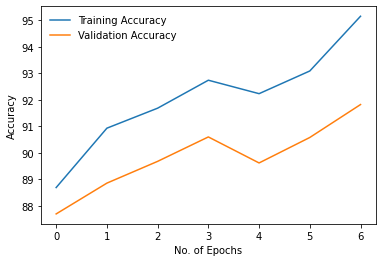

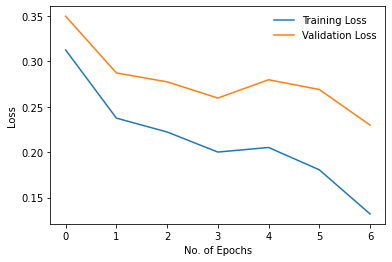

State:
	iteration: 3283
	epoch: 7
	epoch_length: 469
	max_epochs: 7
	output: 0.21604293584823608
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

In [20]:
trainer.run(train_loader, max_epochs=epochs)
